In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from scipy.stats import ttest_ind, linregress
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])


csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))
#Vire les problèmes liés aux ministres
csv = csv[csv["nombredejours"] > 0]
#Vire les contrats courts de début de législature : sans doute la fin d'un contrat de la législature précédente
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]
csv.drop("collaborateurs", 1, inplace=True)

In [21]:
#csv = csv[csv["parlementaire"] == "Delphine O"]
csv.columns

Index(['parlementaire', 'nom_parlementaire', 'prénom_parlementaire',
       'sexe_parlementaire', 'collaborateur', 'nom_collaborateur',
       'prénom_collaborateur', 'sexe_collaborateur', 'url_nosdeputes_api',
       'url_institution', 'information complémentaire', 'date action', 'id',
       'nom', 'nom_de_famille', 'prenom', 'sexe', 'date_naissance',
       'lieu_naissance', 'num_deptmt', 'nom_circo', 'num_circo',
       'mandat_debut', 'mandat_fin', 'ancien_depute', 'groupe_sigle',
       'parti_ratt_financier', 'sites_web', 'emails', 'adresses',
       'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats',
       'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug',
       'url_nosdeputes', 'nb_mandats', 'entree', 'sortie', 'nombredejours',
       'contrat_fini', 'duree_mandat', 'parlementaire_age'],
      dtype='object')

## Le nombre de collaborateurs 

In [22]:
csv.count()['collaborateur']

2981

## Stats sur les collaborateurs


In [23]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("contrat_max")#sort_values("contrat le plus long")
duree_collaborateurs.fillna(150, inplace=True)
duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

Tri par le contrat max pour faire remonter les parlementaires ne gardent aucun collaborateur sur le long terme : 
**ils n'ont pas de fidèles**

In [24]:
duree_collaborateurs

,parlementaire,groupe_sigle,sexe_parlementaire,contrat_mediane,nb_collaborateurs,duree_mandat,contrat_max,contrat_min,contrat_fini_max,contrat_fini_min,ancien_depute,ratio_contrat_mandat,nb_mandats,parlementaire_age
339,Manuéla Kéclard-Mondésir,GDR,F,51.333333,3,66,54.0,50.0,150.0,150.0,False,0.777778,1,47
510,Sylvain Brial,NI,H,54.000000,1,74,54.0,54.0,150.0,150.0,False,0.729730,1,53
36,Antoine Savignat,LR,H,106.000000,1,144,106.0,106.0,150.0,150.0,False,0.736111,1,42
232,Isabelle Muller-Quoy,LREM,F,113.500000,2,148,116.0,111.0,116.0,111.0,True,0.766892,1,50
300,José Evrard,NI,H,101.428571,7,373,154.0,57.0,154.0,57.0,False,0.271926,2,72
416,Olivier Dussopt,NG,H,135.750000,4,186,154.0,81.0,154.0,81.0,True,0.729839,2,39
434,Patrick Vignal,LREM,H,81.666667,12,373,170.0,10.0,90.0,10.0,False,0.218945,1,60
22,Anissa Khedher,LREM,F,78.875000,8,373,170.0,5.0,170.0,5.0,False,0.211461,1,38
382,Michèle Victory,NG,F,169.333333,3,186,170.0,168.0,150.0,150.0,False,0.910394,1,59
109,Claire Guion-Firmin,LR,F,170.000000,2,373,187.0,153.0,187.0,187.0,False,0.455764,1,60


Les fidèles sont représentés par le palier supérieur à droite du graph suivant : la durée de leur contrat est égale à la durée de la législature.

Hypothèses pour le second palier à 300 jours : ce sont les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

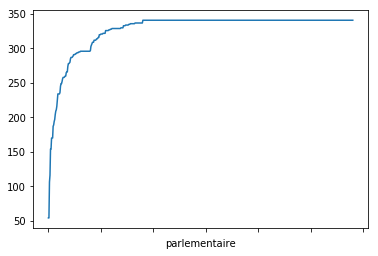

In [43]:
duree_collaborateurs.set_index("parlementaire")["contrat_max"].plot()

Tri par la durée du contrat le plus court de chaque parlementaire

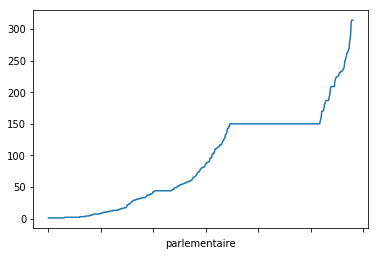

In [45]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Plus de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois.

(La période d'essai d'un CDI de collaborateur est de 2 ou 4 mois)

In [27]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 120]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

56.970740103270224

## Par groupe politique

Les durées médianes de contrat par groupe politique.

In [47]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,199.609107
LREM,217.571973
MODEM,217.639539
LR,227.961640
GDR,238.278758
LFI,241.306022
NG,243.174270
UAI,245.234740


# Par sexe

Les durées médianes de contrat par parlementaire pour les collaborateurs femmes et hommes.

In [48]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()

In [49]:
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].size().to_frame("nombredecollab")

In [53]:
duree_moy_sexe["nombredecollab"] = nb_collab_sexe["nombredecollab"]

In [58]:
duree_moy_sexe

nombredejours  \
parlementaire              sexe_parlementaire sexe_collaborateur                  
Adrien Morenas             H                  F                      327.000000   
                                              H                      329.000000   
Adrien Quatennens          H                  H                      318.333333   
Adrien Taquet              H                  F                      247.000000   
                                              H                      156.666667   
Agnès Firmin Le Bodo       F                  F                      329.250000   
Agnès Thill                F                  F                      245.000000   
                                              H                      302.000000   
Aina Kuric                 F                  F                      318.500000   
                                              H                      197.333333   
Alain Bruneel              H                  F                      281.333333   
                                              H                      212.000000   
Alain David                H                  F                      309.000000   
                                              H                      135.333333   
Alain Perea                H                  F                      295.000000   
                                              H                      187.250000   
Alain Ramadier             H                  F                      292.000000   
                                              H                      316.500000   
Alain Tourret              H                  F                      341.000000   
                                              H                      247.333333   
Albane Gaillot             F                  F                      180.000000   
                                              H                      165.000000   
Alexandra Louis            F                  F                       75.500000   
                                              H                      265.000000   
Alexandra Valetta Ardisson F                  F                      167.800000   
                                              H                       77.000000   
Alexandre Freschi          H                  F                      111.333333   
                                              H                       43.500000   
Alexandre Holroyd          H                  F                      260.000000   
                                              H                      260.000000   
...                                                                         ...   
Élodie Jacquier-Laforge    F                  F                      312.500000   
                                              H                      182.000000   
Émilie Bonnivard           F                  F                      131.250000   
                                              H                      208.000000   
Émilie Cariou              F                  F                      337.000000   
                                              H                      283.250000   
Émilie Chalas              F                  F                      195.000000   
                                              H                      294.000000   
Émilie Guerel              F                  F                      266.333333   
                                              H                       63.800000   
Éric Alauzet               H                  F                      139.000000   
                                              H                      192.400000   
Éric Bothorel              H                  F                      176.000000   
                                              H                      341.000000   
Éric Ciotti                H                  F                      325.500000   
                                              H                       60.500000   

# Test statistiques sur les parlementaires

In [64]:
duree_tt = duree_collaborateurs#.drop(["contrat_fini_max", "contrat_fini_min"], 1)
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

## T-Test : test de significativité des différentes variables dichotomiques.

Pour chacune des variables booléennes décrivant les parlementaires, on effectue un test qui nous indique son effet sur la durée médiane de ses contrats.

In [65]:
for i in duree_tt.drop(["nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min"], 1).columns[4:]:
    cat1 = duree_tt[duree_tt[i] == 0]["contrat_mediane"]
    cat2 = duree_tt[duree_tt[i] == 1]["contrat_mediane"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 1.457828, 0.145430

parlementaire_femme : 3.454622, 0.000591

parlementaire_homme : -3.454622, 0.000591

parlementaire_has_autre_mandats non significatif

groupe_GDR non significatif

groupe_NI : 1.600560, 0.110020

groupe_LR non significatif

groupe_LREM : 2.143225, 0.032511

groupe_NG : -1.733103, 0.083610

groupe_UAI : -1.976073, 0.048621

groupe_MODEM non significatif

groupe_LFI non significatif



### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée médiane de ses contrats.

nb_collaborateurs : slope:-0.019951, intercept:9.580288, 
	rvalue:-0.685975, pvalue:0.000000, stderr:0.000000



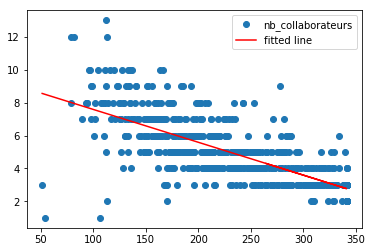

duree_mandat : slope:0.125057, intercept:338.940988, 
	rvalue:0.222256, pvalue:0.000000, stderr:0.000000



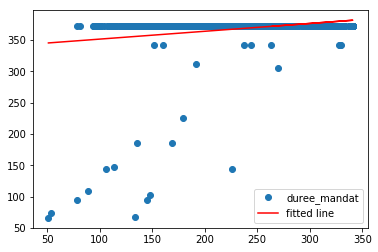

contrat_max : slope:0.226911, intercept:275.991446, 
	rvalue:0.415606, pvalue:0.000000, stderr:0.000000



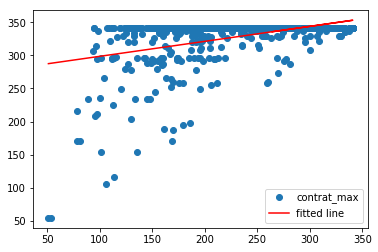

contrat_min : slope:1.346532, intercept:-199.614386, 
	rvalue:0.823998, pvalue:0.000000, stderr:0.000000



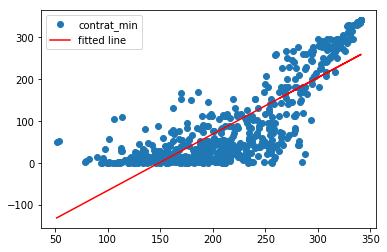

contrat_fini_max : non significatif

contrat_fini_min : slope:0.698483, intercept:-64.333833, 
	rvalue:0.622627, pvalue:0.000000, stderr:0.000000



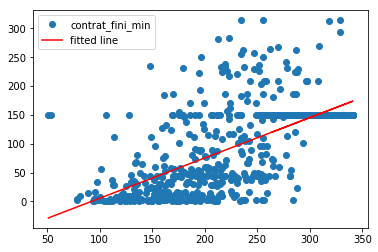

ancien_depute : non significatif

ratio_contrat_mandat : slope:0.002358, intercept:0.089167, 
	rvalue:0.801787, pvalue:0.000000, stderr:0.000000



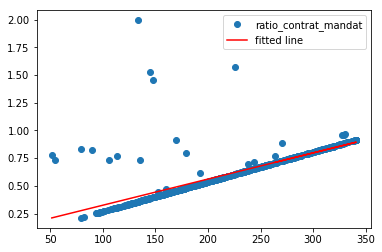

nb_mandats : non significatif

parlementaire_age : slope:0.025335, intercept:44.045205, 
	rvalue:0.152118, pvalue:0.000233, stderr:0.000233



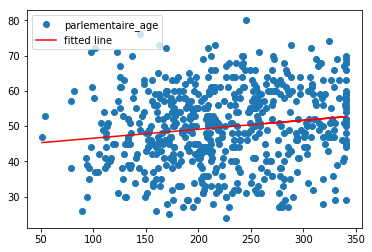

parlementaire_femme : slope:-0.001042, intercept:0.624788, 
	rvalue:-0.142112, pvalue:0.000591, stderr:0.000591



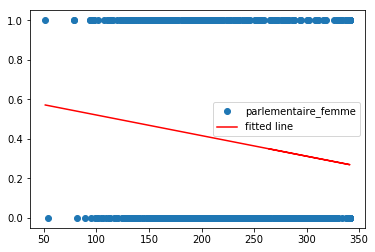

parlementaire_homme : slope:0.001042, intercept:0.375212, 
	rvalue:0.142112, pvalue:0.000591, stderr:0.000591



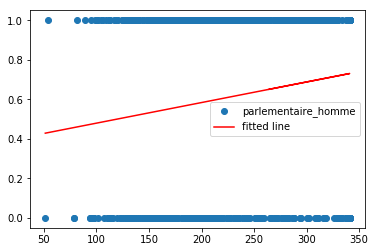

parlementaire_has_autre_mandats : non significatif

groupe_GDR : non significatif

groupe_NI : non significatif

groupe_LR : non significatif

groupe_LREM : slope:-0.000664, intercept:0.688499, 
	rvalue:-0.088718, pvalue:0.032511, stderr:0.032511



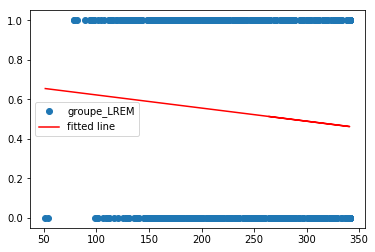

groupe_NG : slope:0.000242, intercept:-0.000707, 
	rvalue:0.071839, pvalue:0.083610, stderr:0.083610



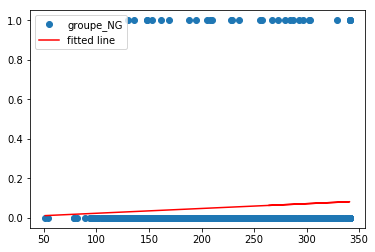

groupe_UAI : slope:0.000284, intercept:-0.006637, 
	rvalue:0.081847, pvalue:0.048621, stderr:0.048621



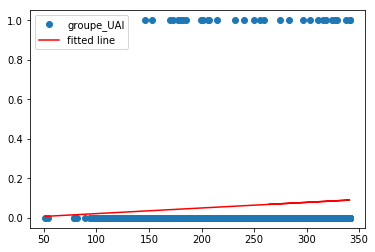

groupe_MODEM : non significatif

groupe_LFI : non significatif



In [66]:
tt = {}
for i in duree_tt.columns[4:]:
    tt[i] = linregress(duree_tt["contrat_mediane"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_mediane"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_mediane"], tt[i].intercept + tt[i].slope*duree_tt["contrat_mediane"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

# Tests statistiques sur les collaborateurs

In [67]:
tous_collaborateurs = csv.merge(duree_collaborateurs, on="parlementaire")
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")

In [68]:
for i in duree_tt.drop(["nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min"], 1).columns[4:]:
    cat1 = duree_tt[duree_tt[i] == 0]["contrat_mediane"]
    cat2 = duree_tt[duree_tt[i] == 1]["contrat_mediane"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 1.457828, 0.145430

parlementaire_femme : 3.454622, 0.000591

parlementaire_homme : -3.454622, 0.000591

parlementaire_has_autre_mandats non significatif

groupe_GDR non significatif

groupe_NI : 1.600560, 0.110020

groupe_LR non significatif

groupe_LREM : 2.143225, 0.032511

groupe_NG : -1.733103, 0.083610

groupe_UAI : -1.976073, 0.048621

groupe_MODEM non significatif

groupe_LFI non significatif

